<a href="https://colab.research.google.com/github/mmillet88/russian_therapy/blob/main/emotion_classifier_2nd_finetune_distilrubert_tiny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading libaries

In [ ]:
!pip install transformers sentencepiece datasets

In [ ]:
import os
import pandas as pd 
import matplotlib.pyplot as plt

from transformers import AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
from transformers import BertForSequenceClassification, AutoTokenizer
from transformers import EarlyStoppingCallback
from transformers import (
    glue_tasks_num_labels,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    GlueDataset,
    GlueDataTrainingArguments,
    TrainingArguments,
)
import torch
import torch.nn as nn
from torch.nn.functional import cross_entropy
import gc

import datasets
from datasets import load_dataset
from datasets import DatasetDict

import numpy as np
from numpy.lib.function_base import average

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [ ]:
# only run for Hyperparameter tuning

!pip install ray torch torchvision
from ray import tune

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.examples.pbt_transformers.utils import (
    download_data,
    build_compute_metrics_fn,
)
from ray.tune.schedulers import PopulationBasedTraining

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59.4 MB 1.4 MB/s 
     |████████████████████████████████| 8.8 MB 46.2 MB/s 
     |████████████████████████████████| 4.1 MB 50.2 MB/s 
     |████████████████████████████████| 466 kB 60.2 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.47.0
    Uninstalling grpcio-1.47.0:
      Successfully uninstalled grpcio-1.47.0


In [ ]:
# only run for baseline model - transformers as feature extractors

!pip install umap-learn==0.5.2

from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 86 kB 4.5 MB/s 
     |████████████████████████████████| 1.1 MB 21.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=4738a9efb5d4a529ce1e997cd1f9eddb8b5278d5e47a35026fe298712825ee6d
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=debab6df740e90ccdd9f47ac90e045e6ff8c5c3d3604f483cc03aa7aa047a980
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


# Loading datasets and converting into Dataset class (Huggingface library)

## Downloading data

In [ ]:
# Downloading CEDR dataset

dataset_url = 'https://sagteam.ru/cedr/main.zip'
!wget --no-check-certificate  {dataset_url}
!mkdir emp_chatbot
!mkdir emp_chatbot/data
!unzip main.zip -d /content/emp_chatbot/data/

--2022-08-25 21:43:55--  https://sagteam.ru/cedr/main.zip
Resolving sagteam.ru (sagteam.ru)... 194.87.238.135
Connecting to sagteam.ru (sagteam.ru)|194.87.238.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 693026 (677K) [application/zip]
Saving to: ‘main.zip’

main.zip            100%[===================>] 676.78K   776KB/s    in 0.9s    

2022-08-25 21:43:57 (776 KB/s) - ‘main.zip’ saved [693026/693026]

Archive:  main.zip
replace /content/emp_chatbot/data/main/test.jsonl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/emp_chatbot/data/main/test.jsonl  
  inflating: /content/emp_chatbot/data/main/train.jsonl  


In [ ]:
# Downloading datasets: "fear" and "anger" data from crowdsourcing Yandex.toloka and EmpatheticPersonaRU - crowdsorced dataset Yandex.toloka

os.chdir('/content/emp_chatbot/data/main')
!gdown --id 1kQuXINwZHOGbjmYS9bUlUPZUWBvkGR5T
!gdown --id 1Jg8SxZxisOwVwZS-5CvE75AxzKl0KYAE
!gdown --id 1sB79t7zO6AoHYJzqXTQ34fEeIyRbvaf6


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1kQuXINwZHOGbjmYS9bUlUPZUWBvkGR5T
To: /content/emp_chatbot/data/main/fear_for_cedr.json
100% 489k/489k [00:00<00:00, 152MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Jg8SxZxisOwVwZS-5CvE75AxzKl0KYAE
To: /content/emp_chatbot/data/main/anger_for_cedr.json
100% 457k/457k [00:00<00:00, 134MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file I

## Assembling a Dataset class and creating train/test/validation splits for both cedr(augmented)  and epru datasets

In [ ]:
# Assembling a Dataset class for both augmented CEDR and EPRU

data_files = {"train": ["train.jsonl", "test.jsonl","fear_for_cedr.json",'anger_for_cedr.json']}
cedr = load_dataset('json', data_files=data_files)
data_files_EPru = {"train": "emotions_utterances.json"}
epru = load_dataset('json', data_files=data_files_EPru)
epru.shuffle(seed=42)
cedr.shuffle(seed=42)
# !head -n 102 emotions_utterances.csv

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-540b76648fb02821/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-14b3a915781501bd/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'source'],
        num_rows: 10946
    })
})

In [ ]:
# create a train/validation/test set

train_validation_test_cedr = cedr['train'].train_test_split(shuffle=True, seed=200, test_size=0.3)
train_validation_test_epru = epru['train'].train_test_split(shuffle=True, seed=200, test_size=0.3)
validation_test_cedr = train_validation_test_cedr['test'].train_test_split(shuffle=True, seed=200, test_size=0.5)
validation_test_epru = train_validation_test_epru['test'].train_test_split(shuffle=True, seed=200, test_size=0.5)
# create cedr dataset
cedr = DatasetDict({
    'train': train_validation_test_cedr['train'],
    'validation': validation_test_cedr['train'],
    'test': validation_test_cedr['test']})

# create epru dataset
epru = DatasetDict({
    'train': train_validation_test_epru['train'],
    'validation': validation_test_epru['train'],
    'test': validation_test_epru['test']})

## Filtering augmented cedr dataset

In [ ]:
train_ds = cedr['train']
train_ds[5]

{'text': 'В то же время в прайде начались жестокие драки, и мы были вынуждены кого-то оттуда забрать», — объяснил произошедшее директор.',
 'labels': [],
 'source': 'lenta'}

In [ ]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'source': Value(dtype='string', id=None)}


In [ ]:
# removing text with more than 1 label or labelled "surpised"

cedr = cedr.filter(lambda row: 0 < len(row['labels']) < 2 and row['labels']!=['surprise'] and row['text']!="")
# creating label representation as a string
cedr = cedr.map(lambda x: {'label': x['labels'][0]}, remove_columns=['labels'])
cedr

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4397 [00:00<?, ?ex/s]

  0%|          | 0/958 [00:00<?, ?ex/s]

  0%|          | 0/951 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 4397
    })
    validation: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 958
    })
    test: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 951
    })
})

In [ ]:
# Adding a column with punctuation removed

def remove_punctuation(row):
  punctuation = ')£;-(:'
  text_no_punct = ''.join([element for element in row['text'] if element not in punctuation])
  return {'text_no_punct': text_no_punct}
cedr = cedr.map(remove_punctuation)
epru = epru.map(remove_punctuation)
# inspecting features

  0%|          | 0/4397 [00:00<?, ?ex/s]

  0%|          | 0/958 [00:00<?, ?ex/s]

  0%|          | 0/951 [00:00<?, ?ex/s]

  0%|          | 0/762 [00:00<?, ?ex/s]

  0%|          | 0/163 [00:00<?, ?ex/s]

  0%|          | 0/164 [00:00<?, ?ex/s]

In [ ]:
# encoding label as a class

cedr = cedr.class_encode_column('label')
epru = epru.class_encode_column('label')

Casting to class labels:   0%|          | 0/5 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# checking that label column is inded of ClassLabel type

epru['train'].features

{'age': Value(dtype='string', id=None),
 'sex': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=4, names=['anger', 'fear', 'joy', 'sadness'], id=None),
 'text_no_punct': Value(dtype='string', id=None)}

In [ ]:
cedr['train'].features

{'text': Value(dtype='string', id=None),
 'source': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=4, names=['anger', 'fear', 'joy', 'sadness'], id=None),
 'text_no_punct': Value(dtype='string', id=None)}

## Class Distribution visualisation

In [ ]:
# from Dataset to DataFrame for cedr

cedr.set_format(type='pandas')
df = cedr['train'][:]
df.head()

,text,source,label,text_no_punct
0,"Опоздала , теперь боюсь зайти в класс, сижу пр...",twitter,1,"Опоздала , теперь боюсь зайти в класс, сижу пр..."
1,Эх... Цвет почти не отличается от собственного...,twitter,3,Эх... Цвет почти не отличается от собственного...
2,"Ииии комбо!Вечер тоски,ты меня покинешь?",twitter,3,"Ииии комбо!Вечер тоски,ты меня покинешь?"
3,"Доброе утро,правда просыпаться из-за дикой бол...",twitter,3,"Доброе утро,правда просыпаться изза дикой боли..."
4,"Мы не хотим вас огорчать,но..Альбом за день до...",twitter,3,"Мы не хотим вас огорчать,но..Альбом за день до..."


In [ ]:
# from Dataset to DataFrame for epru

epru.set_format(type='pandas')
df_epru = epru['train'][:]
df_epru.head()

,age,sex,text,label,text_no_punct
0,30-39,female,Чувствую себя прекрасно! Проснулся в отличном ...,2,Чувствую себя прекрасно! Проснулся в отличном ...
1,30-39,female,Д вообще жесть. Хочется рвать и метать. Убил б...,0,Д вообще жесть. Хочется рвать и метать. Убил б...
2,50-59,male,В маршрутке была такая давка. Вышла из неё зла...,0,В маршрутке была такая давка. Вышла из неё зла...
3,,,Я просто летаю. Жизнь кажется мне прекрасной и...,2,Я просто летаю. Жизнь кажется мне прекрасной и...
4,,,Чудесная погода. Настроение сегодня отличное. ...,2,Чудесная погода. Настроение сегодня отличное. ...


In [ ]:
# adding a label_name column

def label_int2str(row):
  return cedr['train'].features['label'].int2str(row)
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,source,label,text_no_punct,label_name
0,"Опоздала , теперь боюсь зайти в класс, сижу пр...",twitter,1,"Опоздала , теперь боюсь зайти в класс, сижу пр...",fear
1,Эх... Цвет почти не отличается от собственного...,twitter,3,Эх... Цвет почти не отличается от собственного...,sadness
2,"Ииии комбо!Вечер тоски,ты меня покинешь?",twitter,3,"Ииии комбо!Вечер тоски,ты меня покинешь?",sadness
3,"Доброе утро,правда просыпаться из-за дикой бол...",twitter,3,"Доброе утро,правда просыпаться изза дикой боли...",sadness
4,"Мы не хотим вас огорчать,но..Альбом за день до...",twitter,3,"Мы не хотим вас огорчать,но..Альбом за день до...",sadness


In [ ]:
def label_int2str(row):
  return epru['train'].features['label'].int2str(row)
df_epru['label_name'] = df_epru['label'].apply(label_int2str)
df_epru.head()

,age,sex,text,label,text_no_punct,label_name
0,30-39,female,Чувствую себя прекрасно! Проснулся в отличном ...,2,Чувствую себя прекрасно! Проснулся в отличном ...,joy
1,30-39,female,Д вообще жесть. Хочется рвать и метать. Убил б...,0,Д вообще жесть. Хочется рвать и метать. Убил б...,anger
2,50-59,male,В маршрутке была такая давка. Вышла из неё зла...,0,В маршрутке была такая давка. Вышла из неё зла...,anger
3,,,Я просто летаю. Жизнь кажется мне прекрасной и...,2,Я просто летаю. Жизнь кажется мне прекрасной и...,joy
4,,,Чудесная погода. Настроение сегодня отличное. ...,2,Чудесная погода. Настроение сегодня отличное. ...,joy


In [ ]:
df['label_name'].value_counts(ascending=True)

anger       869
fear       1022
sadness    1213
joy        1293
Name: label_name, dtype: int64

### Plotting labels distribution

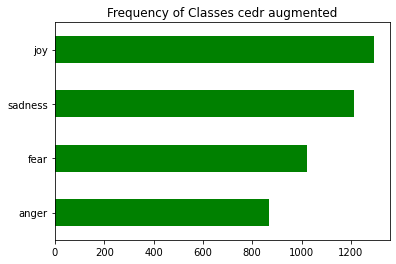

In [ ]:
df['label_name'].value_counts(ascending=True).plot.barh(color='green')
plt.title('Frequency of Classes cedr augmented')
plt.show()

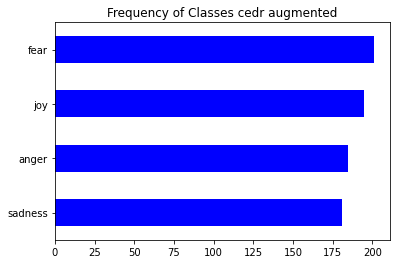

In [ ]:
df_epru['label_name'].value_counts(ascending=True).plot.barh(color='blue')
plt.title('Frequency of Classes cedr augmented')
plt.show()

### Plotting Length of sequence distribution

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


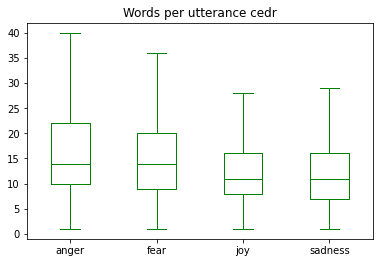

In [ ]:
df['Words per utterance cedr'] = df['text'].str.split().apply(len)
df.boxplot('Words per utterance cedr', by='label_name', grid=False, showfliers=False, color='green')
plt.suptitle('')
plt.xlabel('')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


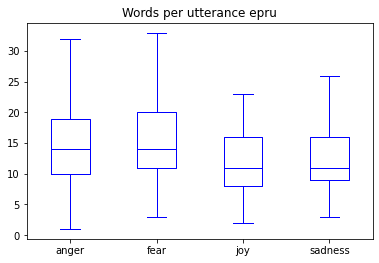

In [ ]:
df_epru['Words per utterance epru'] = df_epru['text'].str.split().apply(len)
df_epru.boxplot('Words per utterance epru', by='label_name', grid=False, showfliers=False, color='blue')
plt.suptitle('')
plt.xlabel('')
plt.show()

Resetting the format of Emotions dataset from dataframe to datasetDictionary

In [ ]:
cedr.reset_format()
epru.reset_format()

# Tokenization

In [ ]:
# loading a tokenizer corresponding to the model

models = ['cointegrated/rubert-tiny2', 'DeepPavlov/rubert-base-cased', 'DeepPavlov/distilrubert-tiny-cased-conversational-v1']
model_ckpt = models[2]
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
# tokenizing the full dataset as a single batch. Two versions: with and without punctuation

def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

def tokenize_no_punct(batch):
  return tokenizer(batch['text_no_punct'], padding=True, truncation=True)

cedr_encoded = cedr.map(tokenize, batched=True, batch_size=None)
cedr_no_punct_encoded = cedr.map(tokenize_no_punct, batched=True, batch_size=None)

epru_encoded = epru.map(tokenize, batched=True, batch_size=None)
epru_no_punct_encoded = epru.map(tokenize_no_punct, batched=True, batch_size=None)
# print(emotions_encoded['train'].column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# inspecting new feaures of the dataset: input ids, attention_mask

epru_encoded.items()

dict_items([('train', Dataset({
    features: ['age', 'sex', 'text', 'label', 'text_no_punct', 'input_ids', 'attention_mask'],
    num_rows: 762
})), ('validation', Dataset({
    features: ['age', 'sex', 'text', 'label', 'text_no_punct', 'input_ids', 'attention_mask'],
    num_rows: 163
})), ('test', Dataset({
    features: ['age', 'sex', 'text', 'label', 'text_no_punct', 'input_ids', 'attention_mask'],
    num_rows: 164
}))])

### Exploring tokens class

In [ ]:
encoded_text = tokenizer('tokenising -  это очень важно!')
print(encoded_text)
encoded_text.items()

{'input_ids': [2, 2824, 20045, 252, 1499, 1931, 45, 426, 675, 2370, 67, 3], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


dict_items([('input_ids', [2, 2824, 20045, 252, 1499, 1931, 45, 426, 675, 2370, 67, 3]), ('attention_mask', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])])

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'to', '##ke', '##n', '##is', '##ing', '-', 'это', 'очень', 'важно', '!', '[SEP]']


In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenising - это очень важно! [SEP]


In [ ]:
print(tokenizer.vocab_size)

30522


In [ ]:
# names of the fields that the model expects in the forward pass

tokenizer.model_input_names

['input_ids', 'attention_mask']

# Training emotions classifier

## Transformers as Feature Extractors

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [ ]:
def extract_hidden_states(batch):
  # place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  # exract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # return vector for CLS token
  return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

In [ ]:
cedr_encoded.set_format('torch', columns=['label','input_ids', 'attention_mask'])

In [ ]:
cedr_hidden = cedr_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
cedr_hidden['train'].column_names

['text',
 'source',
 'label',
 'text_no_punct',
 'input_ids',
 'attention_mask',
 'hidden_state']

### Creating a feature matrix

In [ ]:
X_train = np.array(cedr_hidden['train']['hidden_state'])
X_valid = np.array(cedr_hidden['validation']['hidden_state'])
y_train = np.array(cedr_hidden['train']['label'])
y_valid = np.array(cedr_hidden['validation']['label'])
X_train.shape, X_valid.shape

((4397, 264), (958, 264))

### Visualising the training set

In [ ]:
# Scale features to 0,1 range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialise and fit umap
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
# create a dataframe of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,-1.322987,10.449359,1
1,-0.650739,8.925441,3
2,7.658205,7.664468,3
3,-2.310808,4.530754,3
4,-2.491536,5.562889,3


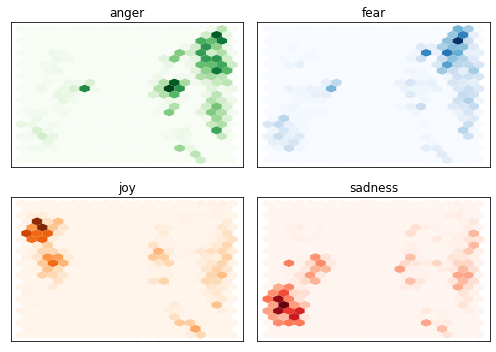

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(7,5))
axes = axes.flatten()
cmaps = ['Greens', 'Blues', 'Oranges', 'Reds']
labels = cedr['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Training a simple classifier - logistic regression (fast and does not require GPU)

In [ ]:
# Transformer basemodel embeddings logistic regression

lr_clf = LogisticRegression(max_iter=3000) #guarantees convergence
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.8058455114822547

In [ ]:
# most_frequent class classifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.30062630480167013

Investigate the performance with a confusion matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

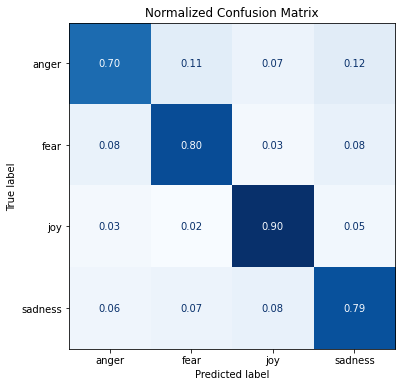

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
f1_score(y_valid, y_preds, average='macro')

0.7978004247184713

## Fine-tuning on cedr (augmented) dataset

In [ ]:
# optional - loging into huggingface to save the model
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_labels = 4
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of the model checkpoint at DeepPavlov/distilrubert-tiny-cased-conversational-v1 were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/distilrubert-tiny-cased-conversational-v1 and are newly initialized

In [ ]:
# specifying metrics for performance evaluation

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  prec = precision_score(labels, preds, average='weighted')
  recall = recall_score(labels, preds, average='weighted')
  return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': recall}

### Hyperparameter search

In [ ]:
def model_init():
    """Returns an initialized model for use in a Hugging Face Trainer."""
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)
    model = model.to('cuda')
    return model

batch_size = 64
logging_steps = len(cedr_encoded['train']) // batch_size
model_name = f"{model_ckpt}_best_finetuned_emotion_experiment_augmented_anger_fear"
training_args = TrainingArguments(output_dir=f'/content/drive/MyDrive/chatbot/{model_name}/',
                                  num_train_epochs=15,
                                  learning_rate =2e-5,
                                  adam_epsilon=1e-6,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  # push_to_hub=True,
                                  log_level='error',
                                  metric_for_best_model = 'f1', # addition
                                  load_best_model_at_end = True,
                                  logging_dir="./logs")

import torch.nn as nn
trainer = Trainer(model_init=model_init, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=cedr['train'],
                  eval_dataset=cedr['validation'],
                  tokenizer=tokenizer,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=5)])

In [ ]:
reporter = CLIReporter(
    parameter_columns={
        "weight_decay": "w_decay",
        "learning_rate": "lr",
        "per_device_train_batch_size": "train_bs/gpu",
        "num_train_epochs": "num_epochs",
    },
    metric_columns=["eval_acc", "eval_loss", "eval_f1", "epoch", "training_iteration"],
)

In [ ]:

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [ ]:
# specifying hyperparameters to run through

tune_config = {
    "learning_rate": tune.choice([1e-5, 2e-5, 1e-4]),
    "weight_decay": tune.choice([0.01, 0.1, 0.2]),
    "adam_epsilon": tune.choice([1e-6,1e-8, 1e-4])
}
trainer.hyperparameter_search(
    direction="maximize", 
    backend="ray",
    hp_space=lambda _: tune_config,
    progress_reporter=reporter, local_dir="~/ray_results/", #local_dir="/content/drive/MyDrive/chatbot/ray_results/", #local_dir="~/ray_results/",
        name="tune_transformer_pbt",
        log_to_file=True,)

### Training


In [ ]:
# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.get("labels")
#         # forward pass
#         outputs = model(**inputs)
#         logits = outputs.get("logits")
#         # compute custom loss (suppose one has 3 labels with different weights)
#         loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([2.0, 2.0, 1.0, 1.0]))
#         loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
#         return (loss, outputs) if return_outputs else loss


In [ ]:
cleanup()

In [ ]:
batch_size = 64
logging_steps = len(cedr['train']) // batch_size
model_name = f"{model_ckpt}_single_finetuned_on_cedr_augmented"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=20,
                                  learning_rate =1e-4,
                                  adam_epsilon=1e-06,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.1,
                                  evaluation_strategy="epoch",
                                  save_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level='error',
                                  metric_for_best_model = 'f1', # addition
                                  load_best_model_at_end = True)
                                  #logging_dir="./logs")


In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=cedr_encoded['train'],
                  eval_dataset=cedr_encoded['validation'],
                  tokenizer=tokenizer,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=5)])

trainer.train()

Cloning https://huggingface.co/mmillet/distilrubert-tiny-cased-conversational-v1_single_finetuned_on_cedr_augmented into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.917200,0.512413,0.824635,0.822011,0.827069,0.824635
2,0.470900,0.427944,0.852818,0.850451,0.858793,0.852818
3,0.319400,0.377017,0.873695,0.872687,0.873956,0.873695
4,0.245900,0.395087,0.868476,0.868207,0.869187,0.868476
5,0.182400,0.400472,0.883090,0.883429,0.884095,0.883090
6,0.151500,0.435584,0.879958,0.879704,0.880053,0.879958
7,0.127400,0.464201,0.872651,0.872589,0.873081,0.872651
8,0.083300,0.522614,0.863257,0.862660,0.863065,0.863257
9,0.073000,0.532719,0.869520,0.868648,0.869159,0.869520
10,0.057500,0.590841,0.865344,0.865609,0.866507,0.865344


Adding files tracked by Git LFS: ['vocab.txt']. This may take a bit of time if the files are large.


TrainOutput(global_step=690, training_loss=0.259579466348109, metrics={'train_runtime': 99.6215, 'train_samples_per_second': 882.741, 'train_steps_per_second': 13.852, 'total_flos': 96836847940560.0, 'train_loss': 0.259579466348109, 'epoch': 10.0})

### Evaluating on valuation dataset

In [ ]:
preds_output = trainer.predict(cedr_encoded['validation'])
preds_output.metrics

{'test_accuracy': 0.8830897703549061,
 'test_f1': 0.8834285787415342,
 'test_loss': 0.40047165751457214,
 'test_precision': 0.8840946259168321,
 'test_recall': 0.8830897703549061,
 'test_runtime': 0.4188,
 'test_samples_per_second': 2287.365,
 'test_steps_per_second': 35.815}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = preds_output.label_ids
labels = cedr_encoded['train'].features['label'].names

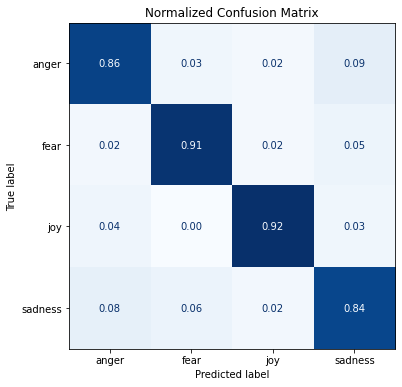

In [ ]:
# Extracting predicted vs valid labels to plot a confusion matrix

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = preds_output.label_ids
labels = cedr_encoded['train'].features['label'].names

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

### Evaluating on test dataset

In [ ]:
test_preds_output = trainer.predict(cedr_encoded['test'])
test_preds_output.metrics

{'test_accuracy': 0.8675078864353313,
 'test_f1': 0.8683273894396106,
 'test_loss': 0.4682151973247528,
 'test_precision': 0.8740480302470683,
 'test_recall': 0.8675078864353313,
 'test_runtime': 0.7317,
 'test_samples_per_second': 1299.642,
 'test_steps_per_second': 20.499}

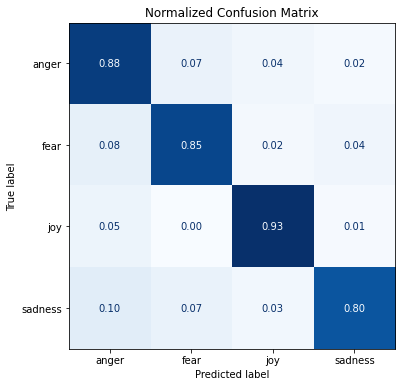

In [ ]:
y_preds = np.argmax(test_preds_output.predictions, axis=1)
y_valid = test_preds_output.label_ids
labels = cedr_encoded['train'].features['label'].names
plot_confusion_matrix(y_preds, y_valid, labels)

### Error Analysis - Create a DataFrame with the texts, losses and predicted/true labels

In [ ]:
# Create a DataFrame with the texts, losses and predicted/true labels

def forward_pass_with_label(batch):
  #Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch['label'].to(device),
                         reduction="none")
    # Place outputs on the GPU for compatibility with other dataset columns
    return {'loss': loss.cpu().numpy(),
            'predicted_label': pred_label.cpu().numpy()}      

In [ ]:
# Convert dataset back to Pytorch tensors
cedr_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
# Comput loss function
cedr_encoded['validation'] = cedr_encoded['validation'].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/60 [00:00<?, ?ba/s]

In [ ]:
cedr_encoded.set_format('pandas')
cols = ['text', 'label', 'predicted_label', 'loss']
df_test = cedr_encoded['validation'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = df_test['predicted_label'].apply(label_int2str)

In [ ]:
df_test.sort_values('loss', ascending=False).head(10)

,text,label,predicted_label,loss
26,"Я в сердце нашла уголок , Он чист и не тесен ,...",joy,anger,6.975439
864,"Ах , этот свежий горный воздух , этот привкус ...",joy,anger,6.639734
72,"Многие ужасные вещи выглядят смешными , эмоция...",joy,anger,6.535662
332,"Издание отмечает, что он явно вышел из себя из...",anger,sadness,6.129594
421,Четыре недели страданий и вот она я с новыми з...,joy,sadness,6.115361
94,"Я ничем не заслужила той ненависти , презрения...",sadness,anger,6.036885
405,Решил скачать сериал Lost) Что-то вдруг захоте...,sadness,joy,6.007910
41,"Но коварны они тем , что съесть их надо за оди...",sadness,anger,5.777278
236,"В очередной раз убеждаюсь, что МЫ сами создаем...",joy,anger,5.765914
49,(( Я сейчас просто смотрю ужасы и у меня телеф...,fear,sadness,5.670051


In [ ]:
df_test.sort_values('loss', ascending=True).head(10)

,text,label,predicted_label,loss
504,Я ненавижу свою жизнь. В жизни нет смысла. Я о...,anger,anger,0.002933
301,"мне очень понравилось про ""мы покакали"" и мест...",joy,joy,0.003061
134,"Мне пожелали удачи на сессичных,люблю гимназис...",joy,joy,0.003074
101,"Катя, ты хорошая девочка, просто надо поверить...",joy,joy,0.003088
71,"Толтко, что разговаривала с начальником по тел...",anger,anger,0.003187
925,"Чуствую себя очень яростно, меня бросил муж. О...",anger,anger,0.003207
941,Я очень зол на этот мир. Моему возмущению нет ...,anger,anger,0.003227
726,Я очень зол. Меня не понимают и не слышат бли...,anger,anger,0.003240
275,Меня бесит что на работе ты отработанный матер...,anger,anger,0.003247
299,Вечно пустой кошелёк. Уже злит это безденежье!,anger,anger,0.003258


### Saving model

In [ ]:
trainer.push_to_hub(commit_message='pre-trained on augmented cedr (fear and anger added from crowdsourcing)')

### Testing model

In [ ]:
# testing
model_n = model_name.split('/')[1]
model_id=f'mmillet/{model_n}'
classifier = pipeline('text-classification', model=model_id)
custom_sentence = "Я просто вне себя от моих студентов! Какими же нужно быть безразличными, чтобы так относиться к итоговым тестам! Я просто не знаю, как их ещё можно мотивировать!"
preds = classifier(custom_sentence, return_all_scores=True)

IndexError: ignored

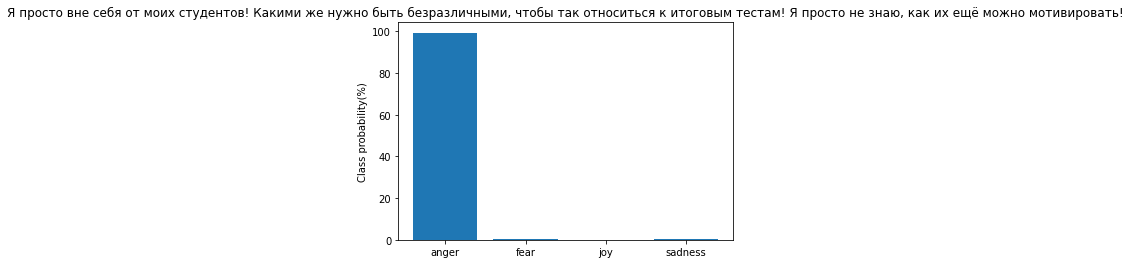

In [ ]:
# visualising prediction
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df['score'])
plt.title(f"{custom_sentence}")
plt.ylabel('Class probability(%)')
plt.show()


## Further Finetuning on EPRU

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
# model_n = model_name.split('/')[1]
model_n = 'distilrubert-tiny-cased-conversational-v1_single_finetuned_on_cedr_augmented'
model_ckpt = f'mmillet/{model_n}'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
# specifying metrics for performance evaluation

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  prec = precision_score(labels, preds, average='weighted')
  recall = recall_score(labels, preds, average='weighted')
  return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': recall}

In [ ]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

def tokenize_no_punct(batch):
  return tokenizer(batch['text_no_punct'], padding=True, truncation=True)
# tokenize function will be applied on the full dataset as a single batch. 
# the input tensors and attention masks have the same shape globally

epru_encoded = epru.map(tokenize, batched=True, batch_size=None)
epru_no_punct_encoded = epru.map(tokenize_no_punct, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
epru_encoded['train'].features

{'age': Value(dtype='string', id=None),
 'sex': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=4, names=['anger', 'fear', 'joy', 'sadness'], id=None),
 'text_no_punct': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_labels = 4
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

In [ ]:
batch_size = 64
logging_steps = len(epru_encoded['train']) // batch_size
model_name_2nd_finetune = f"distilrubert_tiny-2nd-finetune-epru"
training_args = TrainingArguments(output_dir=model_name_2nd_finetune,
                                  num_train_epochs=20,
                                  learning_rate =1e-4,
                                  adam_epsilon=1e-06,
                                  # learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.1,
                                  evaluation_strategy="epoch",
                                  save_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level='error',
                                  metric_for_best_model = 'f1', # addition
                                  load_best_model_at_end = True)
                                  #logging_dir="./logs")


import torch.nn as nn
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=epru_encoded['train'],
                  eval_dataset=epru_encoded['validation'],
                  tokenizer=tokenizer,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=5)])

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.490400,0.422051,0.883436,0.884281,0.897998,0.883436
2,0.289400,0.307023,0.907975,0.907975,0.907975,0.907975
3,0.233300,0.319432,0.889571,0.889648,0.893180,0.889571
4,0.176500,0.392091,0.883436,0.885013,0.901787,0.883436
5,0.109000,0.340656,0.901840,0.902386,0.912259,0.901840
6,0.098300,0.326156,0.920245,0.919601,0.921577,0.920245
7,0.069500,0.355717,0.901840,0.901690,0.905575,0.901840
8,0.042500,0.318572,0.920245,0.920205,0.921158,0.920245
9,0.054500,0.338594,0.907975,0.908513,0.911365,0.907975
10,0.028400,0.349631,0.914110,0.914174,0.918767,0.914110


TrainOutput(global_step=156, training_loss=0.1182063734337974, metrics={'train_runtime': 18.3646, 'train_samples_per_second': 829.856, 'train_steps_per_second': 13.069, 'total_flos': 11101821730272.0, 'train_loss': 0.1182063734337974, 'epoch': 13.0})

### Evaluating on validation dataset

In [ ]:
preds_output = trainer.predict(epru_encoded['validation'])
preds_output.metrics

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = preds_output.label_ids
labels = epru_encoded['train'].features['label'].names

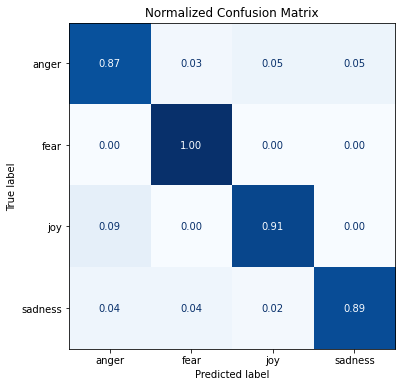

In [ ]:
# Extracting predicted vs valid labels to plot a confusion matrix

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = preds_output.label_ids
labels = epru_encoded['train'].features['label'].names

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

### Evaluating on test dataset


In [ ]:
test_preds_output = trainer.predict(epru_encoded['test'])
test_preds_output.metrics

{'test_loss': 0.2423296421766281,
 'test_accuracy': 0.9390243902439024,
 'test_f1': 0.9388347916418065,
 'test_precision': 0.9397985108677618,
 'test_recall': 0.9390243902439024,
 'test_runtime': 0.0823,
 'test_samples_per_second': 1993.878,
 'test_steps_per_second': 36.473}

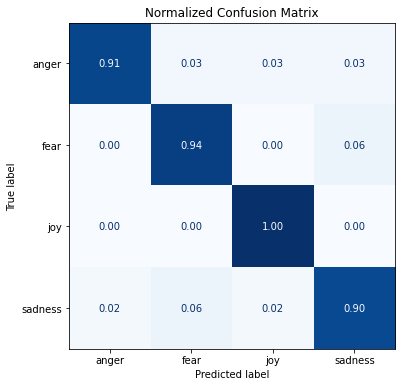

In [ ]:
y_preds = np.argmax(test_preds_output.predictions, axis=1)
y_valid = test_preds_output.label_ids
labels = epru_encoded['test'].features['label'].names
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  plt.show()
plot_confusion_matrix(y_preds, y_valid, labels)

### Push model to huggingface

In [ ]:
trainer.push_to_hub(commit_message="2nd finetuning added more sadness examples")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/39.6M [00:00<?, ?B/s]

Upload file runs/Jun21_14-56-27_fb644efbd957/events.out.tfevents.1655823395.fb644efbd957.582.0:  35%|###5     …

To https://huggingface.co/mmillet/distilrubert_tiny-2nd-finetune-epru
   67c596c..876a7e7  main -> main

To https://huggingface.co/mmillet/distilrubert_tiny-2nd-finetune-epru
   876a7e7..5f7dbf6  main -> main



'https://huggingface.co/mmillet/distilrubert_tiny-2nd-finetune-epru/commit/876a7e78d492c4079cc492a9e445cd83ba4924a9'

### Error Analysis

In [ ]:
# Create a DataFrame with the texts, losses and predicted/true labels

def forward_pass_with_label(batch):
  #Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch['label'].to(device),
                         reduction="none")
    # Place outputs on the GPU for compatibility with other dataset columns
    return {'loss': loss.cpu().numpy(),
            'predicted_label': pred_label.cpu().numpy()}  

In [ ]:
# Convert dataset back to Pytorch tensors
epru_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
# Comput loss function
epru_encoded['test'] = epru_encoded['test'].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/11 [00:00<?, ?ba/s]

In [ ]:
epru_encoded.set_format('pandas')
cols = ['text', 'label', 'predicted_label', 'loss']
df_test = epru_encoded['test'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = df_test['predicted_label'].apply(label_int2str)

In [ ]:
df_test.sort_values('loss', ascending=False).head(10)

,text,label,predicted_label,loss
107,"Не, мы тут сидим и смотрим на то, как Иван сла...",sadness,anger,7.084046
95,Мне очень страшно. Я не чувствую уверенности в...,sadness,fear,6.779366
149,В последние дни мне тревожно. Проблемы на рабо...,sadness,fear,5.730647
142,"Ну почему именно так, почему люди так поступаю...",anger,fear,5.038095
133,"Был магазине, купил молока. Пришел домой, а он...",anger,joy,4.179981
50,"Учащённо бьётся сердце, дрожат руки. Путаются ...",fear,sadness,1.555104
71,Мне сегодня очень плохо. Я сильно переживаю за...,sadness,fear,1.426507
140,"Я отчаянии доктор, я стараюсь, работаю, превоз...",sadness,joy,1.409358
75,Увидел красные глаза залитые кровью. Состояние...,anger,sadness,1.170010
136,Я сегодня плох спал мне предстоит экзамен к ко...,fear,sadness,1.164678


In [ ]:
df_test.sort_values('loss', ascending=True).head(10)

,text,label,predicted_label,loss
153,Я чувствую себя прекрасно! Сегодня замечательн...,joy,joy,0.000687
10,"Всё прекрасно, чувствую себя бодро и свежо.",joy,joy,0.000705
129,"Потрясающе, сегодня волшебный день, все просто...",joy,joy,0.000719
33,Я улыбаюсь незнакомцам на улице и хочу танцева...,joy,joy,0.000741
117,Привет. Чувствую себя прекрасно. День просто о...,joy,joy,0.000746
79,"У меня все отлично! Семья счастлива, на работе...",joy,joy,0.000748
146,Чувствую себя прекрасно. Хорошее состояние. К ...,joy,joy,0.000761
137,У меня всё отлично. На работе повысили и в лич...,joy,joy,0.000779
37,"Я прекрасно себя чувствую, я очень счастлива. ...",joy,joy,0.000785
84,"Отлично, сегодня замечательный день.",joy,joy,0.000798
